In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

## Preparation of data

In [2]:
#set seed for reproduction
set.seed(100)

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.numeric(train.data$Intensity) -1 

data <- x
data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS

In [3]:
set.seed(100)
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- x[idx.train,]
train.y <- train.data$VALENCE.PLEASANTNESS[idx.train]


train <- train.x
train$VALENCE.PLEASANTNESS <- train.y

validation <- x[-idx.train,]
validation$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS[-idx.train]

## Forward Subsetselection (already defined: nvmax_best = 9)

In [7]:
set.seed(100)

library(tidymodels)
library(leaps)


reg.fit <- regsubsets(formula = VALENCE.PLEASANTNESS ~ . , x = train.x, y = train.y , method = "forward", nvmax = 20)

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2728  linear dependencies found"


Reordering variables and trying again:


## Prediction with the 9 selected variables + Plots of these variables vs. VALENCE.PLEASANTNESS

In [8]:
#We have seen by crossvalidation that the best prediction is obtained with 9 predictors
coefi <- coef(reg.fit, id = 9)
names <-names(coefi)
test.mat <- model.matrix(VALENCE.PLEASANTNESS ~ . ,data=validation)
cat("The predictors are:", names)

The predictors are: (Intercept) MATS7i GATS5m Eig08_EA.ri. Mor13i Mor27i nRCOOR C.026 H.052 F01.C.S.

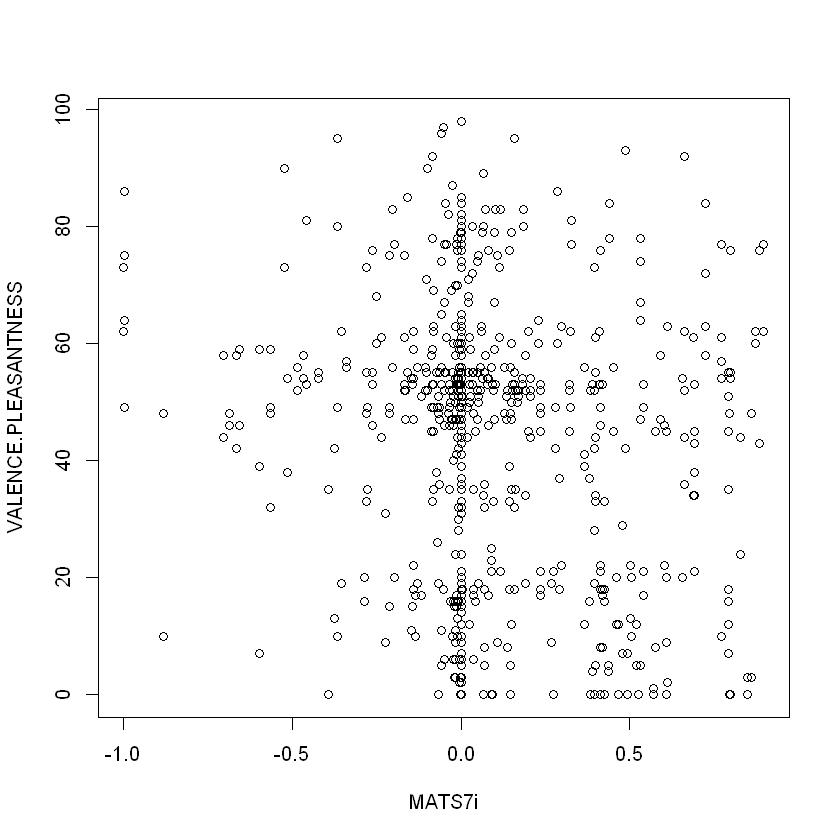

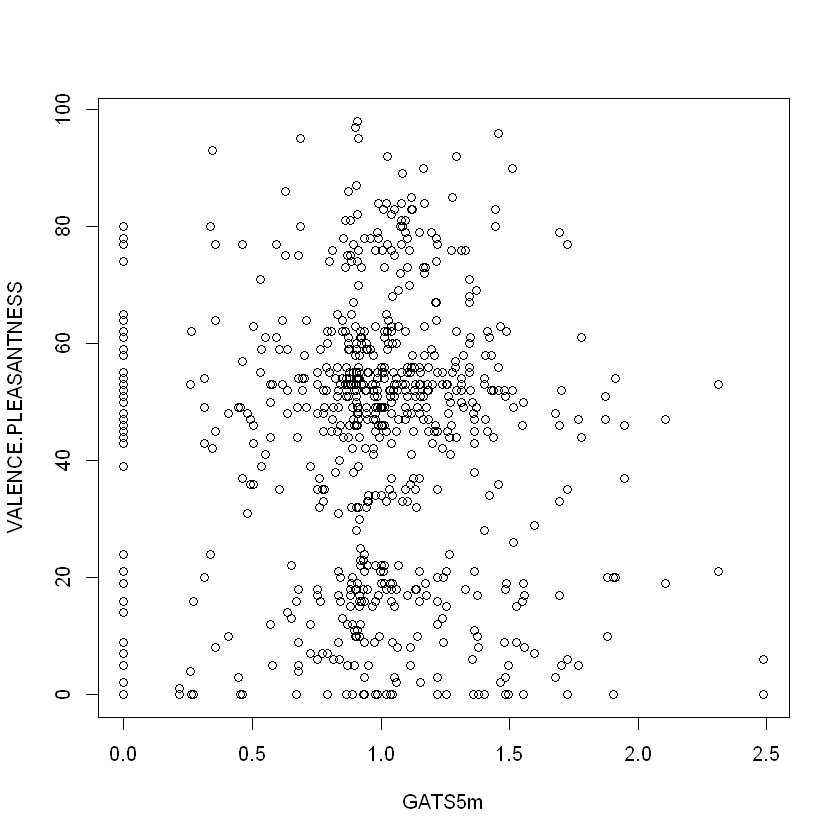

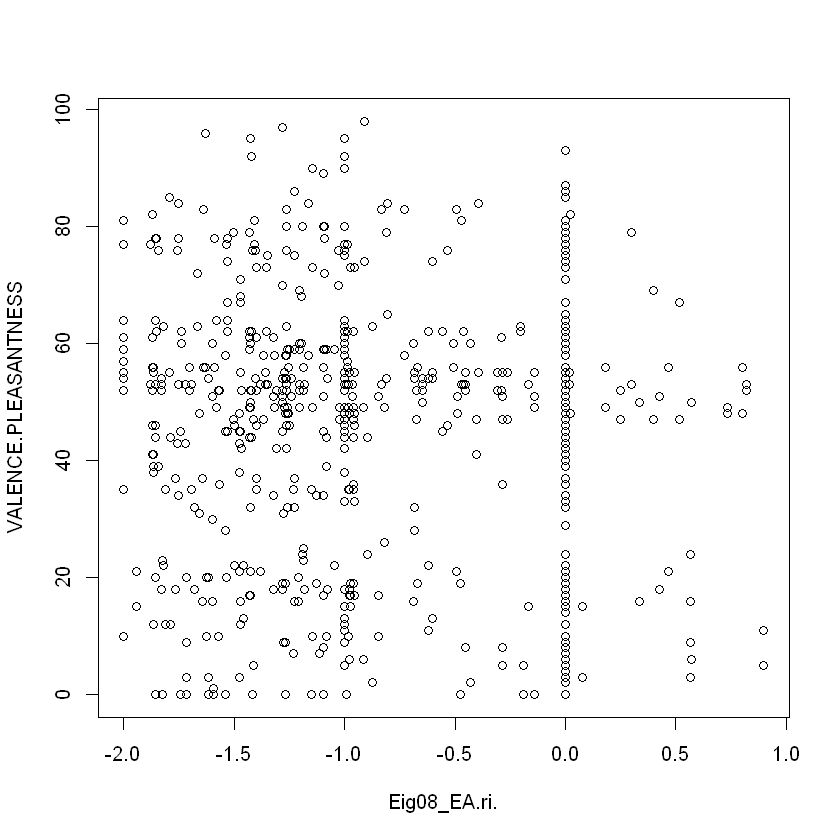

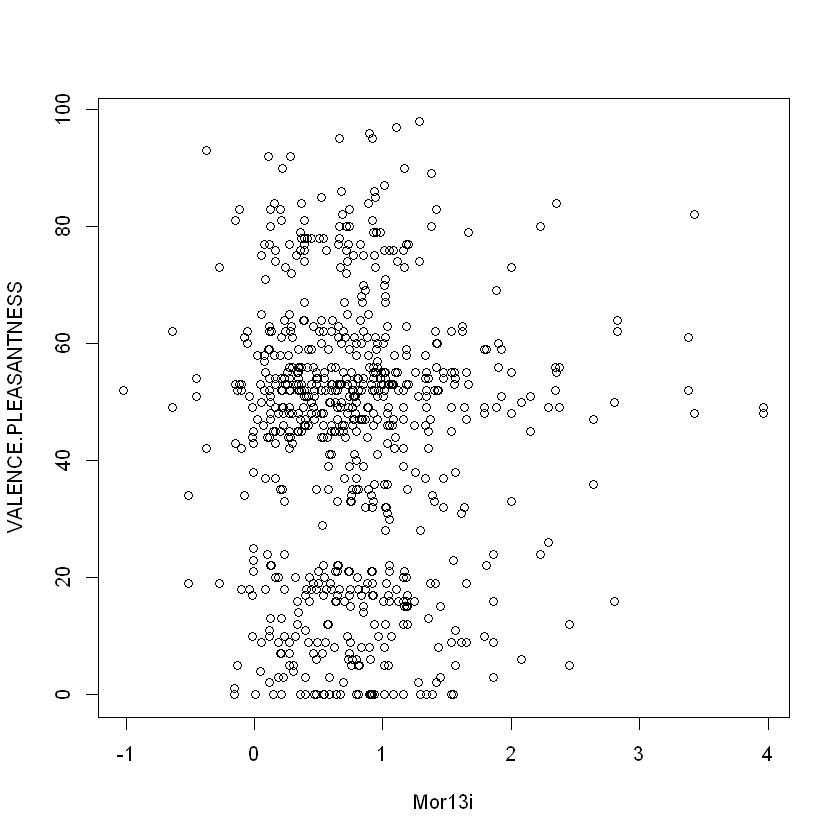

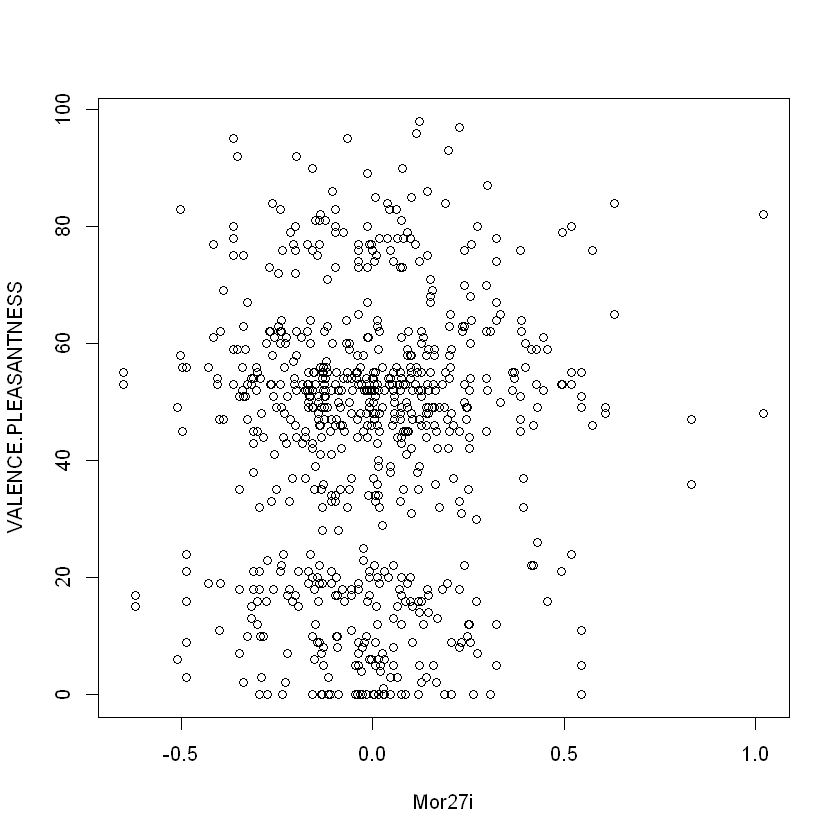

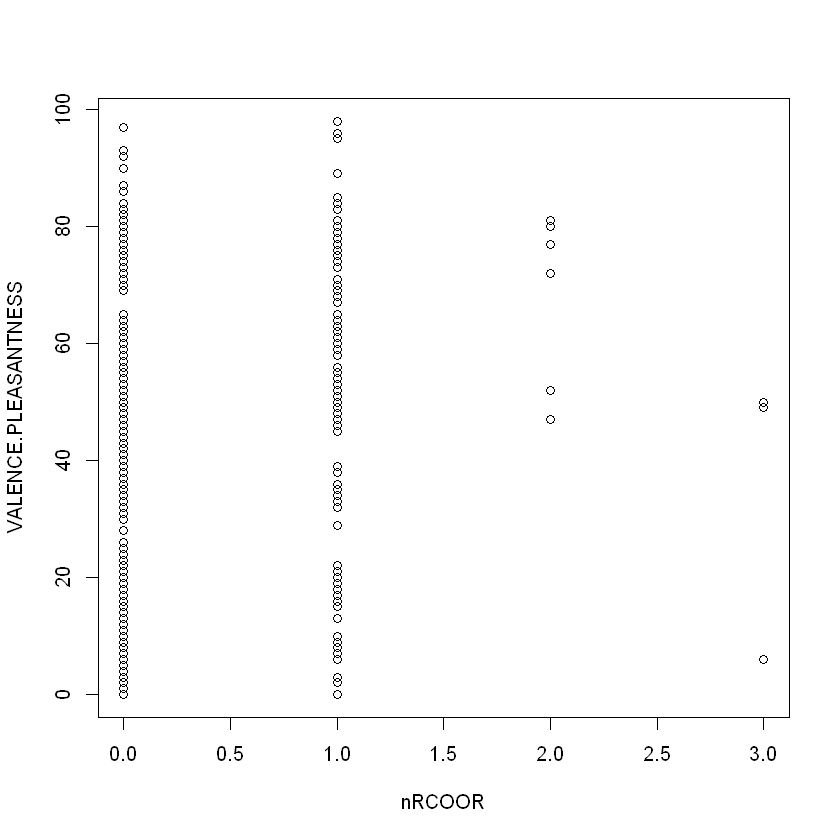

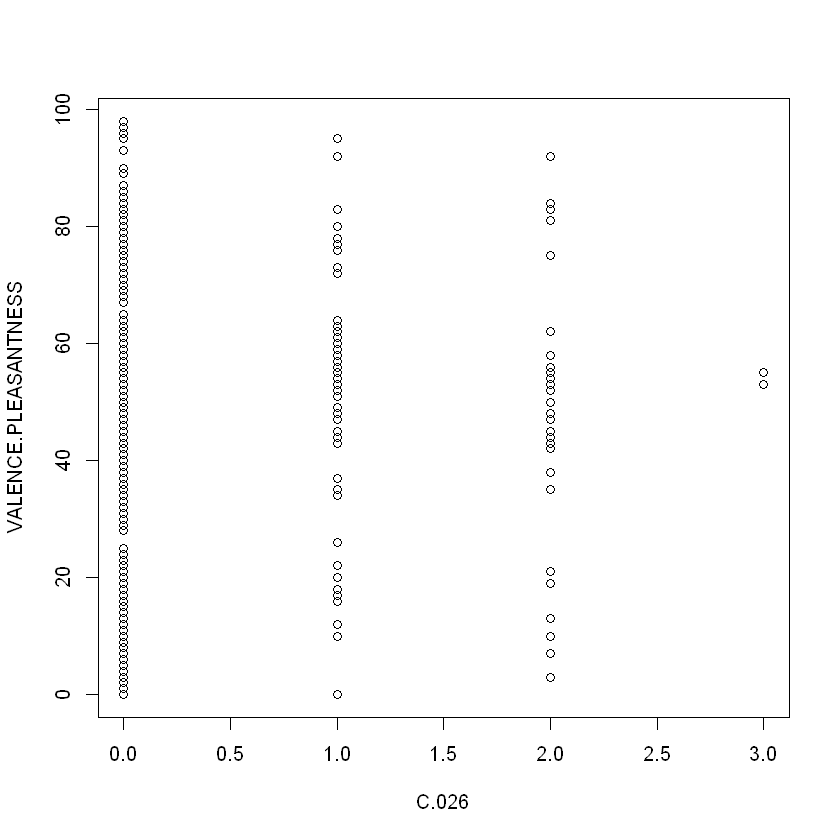

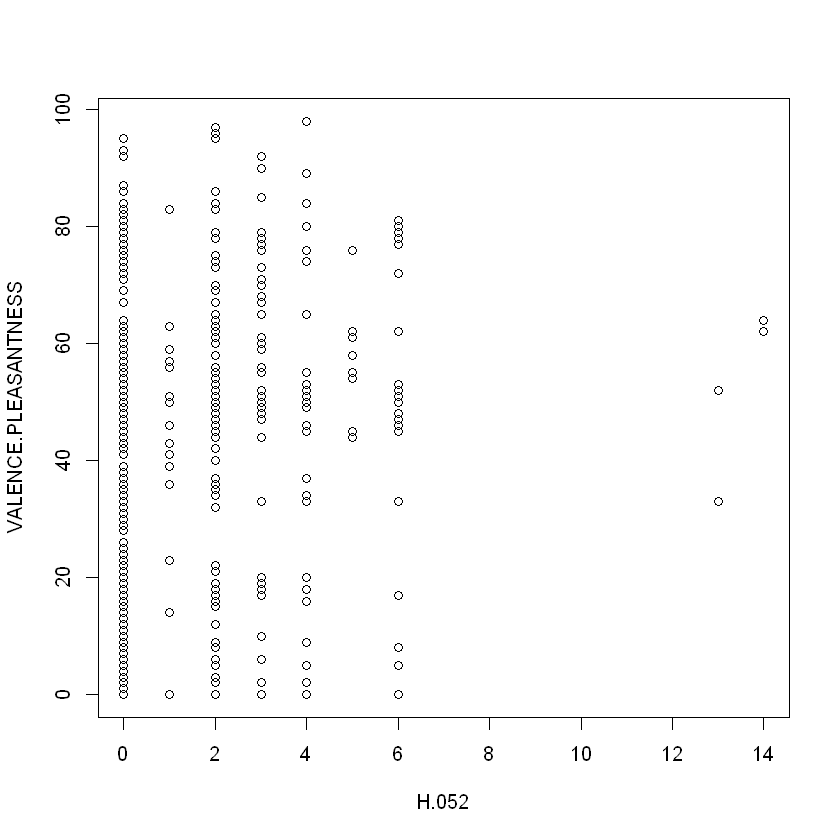

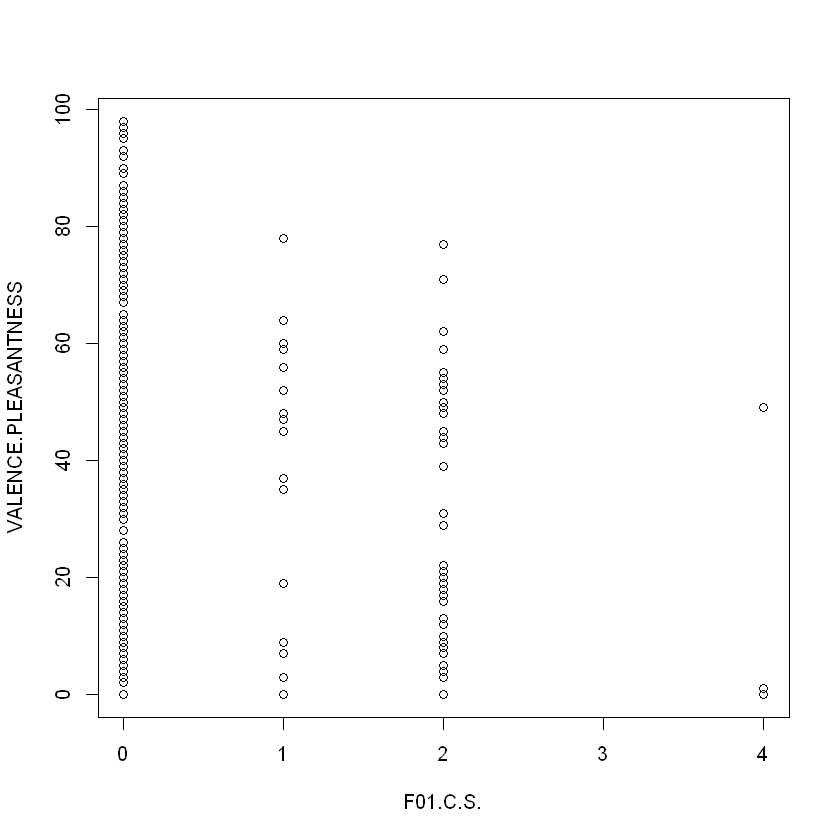

In [8]:
creat.plots <- function(data, x.f, y.f = 'VALENCE.PLEASANTNESS'){
    len <- length(x.f)
    for (i in 1:len){
        formula <- as.formula(paste(y.f, paste(x.f[i], collapse=" + "), sep=" ~ "))
        plot(formula, data)
    }
}

creat.plots(train.data, names[-1])

We can not see any specific non-linear dependency of the predictors to the output variable. Thus, we evaluate all possible polynomial regression by raising the nine predictors to the power 1,2 or 3.

## Crossvalidation to find best combination 

In [14]:
#function to create the formula for a regression. 
#x.f = names of predictors. degrees = powers to which the predictors are raised. y.f = name of respond variable
creat.formula <- function(x.f, degrees, y.f = 'VALENCE.PLEASANTNESS'){
    len <- length(degrees)
    y.f = y.f

    x.f <- sapply(1:len, function(i){
        paste("poly(", x.f[i], ",", degrees[i], ")")
    })
    as.formula(paste(y.f, paste(x.f, collapse = " + "), sep = " ~ "))
    
}

In [457]:
library(tidymodels)
library(leaps)

set.seed(100)


fit_and_evaluate <- function(fold) {
    names <-names
    MSEs <- c()
    
    
    for (i in 1:n.deg){ 
        formula <- creat.formula(names[-1], degrees[i,])
        #regression
        fit <- lm(formula, analysis(fold))
        prediction <- predict(fit, assessment(fold))
        MSE <- mean((prediction - assessment(fold)$VALENCE.PLEASANTNESS)^2)
        MSEs <- append(MSEs, MSE)
    }
    
    MSEs
}

#data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS
validation.data <- vfold_cv(full.data, v = 5)           

#creation of all possible combination for power 1, 2 and 3 with nine predictors (#combination = 3^9 = 19683)
d <- c(1,2,3)
degrees <- expand.grid(d,d,d,d,d,d,d,d,d) 
n.deg <- length(degrees[,1])

#evaluation of the combinations
MSEs <- sapply(validation.data$splits, fit_and_evaluate)

In [458]:
mean.errors <- rowMeans(MSEs)

In [459]:
min <- which.min(mean.errors)
max <- which.max(mean.errors)

mean.errors[min]
degrees[min,]
mean.errors[max]
degrees[max,]

[1] 455.2059

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2326,1,2,1,3,2,1,1,2,1


[1] 479.285

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19467,3,3,3,1,1,3,3,3,3


One can see that the lowest MSE is obtained by the regression with the following formula (with degrees[2326]):\
\
VALENCE.PLEASANTNESS ~ poly(MATS7i, 1) + poly(GATS5m, 2) + poly(Eig08_EA.ri., 1) + poly(Mor13i, 3) + poly(Mor27i, 2) + \
poly(nRCOOR, 1) + poly(C.026, 1) + poly(H.052, 2) + poly(F01.C.S., 1)


In the next two section we evaluate the linear regression with the nine predictors from forward selection (formula obtained with degrees[1])  and the engineered regression with these predictors ((formula obtained with degrees[2326]).

## Validation for forward selection

In [56]:
creat.formula <- function(x.f, degrees, y.f = 'VALENCE.PLEASANTNESS'){
    len <- length(degrees)
    y.f = y.f

    x.f <- sapply(1:len, function(i){
        paste("poly(", x.f[i], ",", degrees[i], ")")
    })
    as.formula(paste(y.f, paste(x.f, collapse = " + "), sep = " ~ "))
    
}

d <- c(1,2,3)
degrees <- expand.grid(d,d,d,d,d,d,d,d,d) 
formula <- creat.formula(names[-1], degrees[1,])


regression.validation <- function(seed){
    set.seed(seed)
    len <- length(data[,1])
    idx.train <- sample(1:len, 2*len/3)
    train <- data[idx.train, ]
    validation <- data[-idx.train, ]
    
    fit <- lm(formula, train)
    prediction <- predict(fit, validation)
    mean((prediction - validation$VALENCE.PLEASANTNESS)^2)
    
}

seeds <- seq.int(100,150)
MSEs <- sapply(seeds, regression.validation)
mean.MSE <- mean(sqrt(MSEs))
var <- var(sqrt(MSEs))
cat("The mean RMSE is = ", mean.MSE, " and the variance is = ", var)


The mean RMSE is =  21.26446  and the variance is =  0.6478304

## Validation for feature Engineering with 9 predictors

In [57]:
d <- c(1,2,3)
degrees <- expand.grid(d,d,d,d,d,d,d,d,d) 
formula <- creat.formula(names[-1], degrees[2326,])

seeds <- seq.int(100,150)
MSEs <- sapply(seeds, regression.validation)
mean.MSE <- mean(sqrt(MSEs))
var <- var(sqrt(MSEs))
cat("The mean RMSE is = ", mean.MSE, " and the variance is = ", var)

The mean RMSE is =  21.18347  and the variance is =  0.6139347

By feature engineering we could slightly reduce the RMSE and the variance. 

## Submission

In [12]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [13]:
#set seed for reproduction
set.seed(100)

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.numeric(train.data$Intensity) -1 

In [14]:
set.seed(100)
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- x[idx.train,]
train.y <- train.data$VALENCE.PLEASANTNESS[idx.train]


train <- train.x
train$VALENCE.PLEASANTNESS <- train.y

validation <- x[-idx.train,]
validation$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS[-idx.train]

In [15]:
library(tidymodels)
library(leaps)


reg.fit <- regsubsets(formula = VALENCE.PLEASANTNESS ~ -1. , x = train.x, y = train.y , method = "forward", nvmax = 20)
coefi <- coef(reg.fit, id = 9)
names <-names(coefi)

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2728  linear dependencies found"


Reordering variables and trying again:


In [16]:
creat.formula <- function(x.f, degrees, y.f = 'VALENCE.PLEASANTNESS'){
    len <- length(degrees)
    y.f = y.f

    x.f <- sapply(1:len, function(i){
        paste("poly(", x.f[i], ",", degrees[i], ")")
    })
    as.formula(paste(y.f, paste(x.f, collapse = " + "), sep = " ~ "))
    
}

In [17]:
d <- c(1,2,3)
degrees <- expand.grid(d,d,d,d,d,d,d,d,d) 
formula <- creat.formula(names[-1], degrees[2326,])

In [ ]:
submission.fit <- lm(formula, train.data)
prediction <- predict(submission.fit, test.data)

In [19]:
#Creation of csv submission-file
submission <- data.frame(Id = 1:68, VALENCE.PLEASANTNESS = prediction)
write.csv(submission, file = "../Submissions/9_predictors.csv", row.names = FALSE)